In [1]:
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

#%matplotlib qt
%matplotlib inline


In [2]:
'''
Read input data
'''
#filename = 'Data/2019H1BCleanedML.csv'
#filename = 'Data/2019H1BNumeric5.csv'
filename = '2019H1BNumericNew1.csv'
data = pd.read_csv(filename)

# dimension and objest types
print(data.shape, '\n')
print(data.dtypes)

data.head(5)

(20652, 13) 

CASE_STATUS                      int64
CASE_SUBMITTED                   int64
SOC_CODE                       float64
FULL_TIME_POSITION               int64
TOTAL_WORKER_POSITIONS           int64
AGENT_REPRESENTING_EMPLOYER    float64
H-1B_DEPENDENT                 float64
WILLFUL_VIOLATOR               float64
NumOfNaN                       float64
PERIOD_OF_EMPLOYMENT_LENGTH      int64
Annual_Wage                      int64
Fortune                          int64
EMPLOYER_REGION                float64
dtype: object


,CASE_STATUS,CASE_SUBMITTED,SOC_CODE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,AGENT_REPRESENTING_EMPLOYER,H-1B_DEPENDENT,WILLFUL_VIOLATOR,NumOfNaN,PERIOD_OF_EMPLOYMENT_LENGTH,Annual_Wage,Fortune,EMPLOYER_REGION
0,0,3,11.0,1,0,1.0,0.0,0.0,5.0,3,0,0,4.0
1,0,1,13.0,1,0,0.0,1.0,0.0,12.0,2,2,0,4.0
2,0,1,15.0,1,0,1.0,0.0,0.0,10.0,3,2,0,2.0
3,0,0,11.0,0,0,0.0,0.0,0.0,18.0,3,2,0,4.0
4,0,2,51.0,1,0,0.0,0.0,0.0,17.0,3,0,0,4.0


In [50]:
# distribution of target
data_size = len(data)
label_0 = len(data[data['CASE_STATUS'] == 0])  # DENIED
label_1 = len(data[data['CASE_STATUS'] == 1])  # CERTIFIED

print("% of CERTIFIED: {:.4f}".format(label_1*100/data_size))
print("% of DENIED: {:.4f}".format(label_0*100/data_size))

% of CERTIFIED: 75.0000
% of DENIED: 25.0000


In [51]:
# Check if there is nan data
data.isnull().sum()

CASE_STATUS                     0
CASE_SUBMITTED                  0
SOC_CODE                        0
FULL_TIME_POSITION              0
TOTAL_WORKER_POSITIONS          0
AGENT_REPRESENTING_EMPLOYER     5
H-1B_DEPENDENT                 20
WILLFUL_VIOLATOR               20
NumOfNaN                        0
PERIOD_OF_EMPLOYMENT_LENGTH     0
Annual_Wage                     0
Fortune                         0
EMPLOYER_REGION                 0
dtype: int64

In [52]:
'''
Preprocessing
'''
# Get column names that contain nan
nan_col = data.columns[data.isna().any()].tolist()
# fill 'nan' with mode number or new value
for col in nan_col:
    data[col] = data[col].fillna(data[col].mode()[0])
    
# Select features
cat_feature = data.columns.values.tolist()
#[cat_feature.remove(col) for col in ['CASE_STATUS','CASE_NUMBER','TOTAL_WORKER_POSITIONS','Wage_year']]
#[cat_feature.remove(col) for col in ['CASE_STATUS','CASE_NUMBER']]
[cat_feature.remove(col) for col in ['CASE_STATUS']]
print(cat_feature)

# Change types of the columns
for col in cat_feature:
    data[col] = data[col].astype(int)
print('\n')
print(data.dtypes)

data.head()

['CASE_SUBMITTED', 'SOC_CODE', 'FULL_TIME_POSITION', 'TOTAL_WORKER_POSITIONS', 'AGENT_REPRESENTING_EMPLOYER', 'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'NumOfNaN', 'PERIOD_OF_EMPLOYMENT_LENGTH', 'Annual_Wage', 'Fortune', 'EMPLOYER_REGION']


CASE_STATUS                    int64
CASE_SUBMITTED                 int64
SOC_CODE                       int64
FULL_TIME_POSITION             int64
TOTAL_WORKER_POSITIONS         int64
AGENT_REPRESENTING_EMPLOYER    int64
H-1B_DEPENDENT                 int64
WILLFUL_VIOLATOR               int64
NumOfNaN                       int64
PERIOD_OF_EMPLOYMENT_LENGTH    int64
Annual_Wage                    int64
Fortune                        int64
EMPLOYER_REGION                int64
dtype: object


,CASE_STATUS,CASE_SUBMITTED,SOC_CODE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,AGENT_REPRESENTING_EMPLOYER,H-1B_DEPENDENT,WILLFUL_VIOLATOR,NumOfNaN,PERIOD_OF_EMPLOYMENT_LENGTH,Annual_Wage,Fortune,EMPLOYER_REGION
0,0,3,11,1,0,1,0,0,5,3,0,0,4
1,0,1,13,1,0,0,1,0,12,2,2,0,4
2,0,1,15,1,0,1,0,0,10,3,2,0,2
3,0,0,11,0,0,0,0,0,18,3,2,0,4
4,0,2,51,1,0,0,0,0,17,3,0,0,4


# Modeling

## Training Model

In [55]:
# randomly split dataset
train, test = train_test_split(data, test_size=0.1, random_state=0)
    
# numpy array
X = train.iloc[:,1:]
y = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

print("train {:5d} {:.2f}".format(len(train), len(train)/len(data)))
print("test {:5d}  {:.2f}".format(len(test), len(test)/len(data)))

train 18586 0.90
test  2066  0.10


In [56]:
'''
Random forest
# n_jobs: num of jobs to run in parallel #
# random_state: seed                     #
'''
# Initial setting
random_state = 386
n_estimators = 200

# Random forest
clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1,
                             random_state=random_state)
clf.fit(X, y)

# Make predictions
pred = clf.predict(X_test)

# Evaluation
te1 = round(np.mean(abs(y_test - pred)), 6)
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)


print('Testing Error:', te1)
print('Accuracy:  {:.6f}'.format(accuracy))
print('F1 score:  {:.6f}'.format(f1))
print('Precision: {:.6f}'.format(precision))
print('Recall:    {:.6f}'.format(recall))

Testing Error: 0.2212
Accuracy:  0.778800
F1 score:  0.860543
Precision: 0.818340
Recall:    0.907336


## Hyper-parameters Tuning
### Random Hyperparameter Grid Search
(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap)

In [57]:
'''
Random Hyperparameter Grid
'''
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [58]:
%%time
'''
Randomized Search
'''
# Use the random grid to search for best hyperparameters
clf_random = RandomizedSearchCV(estimator = clf, 
                                param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose = 2, 
                                random_state = random_state, n_jobs = -1)
# Fit the random search model
clf_random.fit(X, y)

# Find the best estimator
best_random = clf_random.best_estimator_
print(best_random, '\n')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.5min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=386, verbose=0,
                       warm_start=False) 

CPU times: user 19.9 s, sys: 1.2 s, total: 21.1 s
Wall time: 24min 36s


In [10]:
# Evaluate the best model
best_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=-1, oob_score=False, random_state=386, verbose=0,
                       warm_start=False) 

best_clf.fit(X, y)

pred = best_clf.predict(X_test)
te2 = round(np.mean(abs(y_test - pred)), 6)
print('---- Model Performance ----')
print('Best Testing Error:', te2)
print('Improvement: {:2.2f}%\n'.format(100*(te1-te2)/te1))

f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print('Accuracy:  {:.6f}'.format(accuracy))
print('F1 score:  {:.6f}'.format(f1))
print('Precision: {:.6f}'.format(precision))
print('Recall:    {:.6f}'.format(recall))

---- Model Performance ----
Best Testing Error: 0.21394
Improvement: -1.61%

Accuracy:  0.786060
F1 score:  0.866385
Precision: 0.807324
Recall:    0.934768


## Cross-validation
### Final Model

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
'''
Cross Validation
'''

def cross_validation_rf_simple(clf):
    # scores
    f1_scores = []
    accuracy_scores = []
    te_scores = []

    # evaluation methods
    method = ['f1', 'accuracy', 'test error']

    # shuffle split
    shufspl = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=5)

    # full data set
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    
    for train, test in shufspl.split(X):
        # print("train", train, "\ntest", test)
        # fitting and prediction
        clf.fit(X.iloc[train], y.iloc[train])
        cross_pred = clf.predict(X.iloc[test])
        
        # evaluation
        f1 = f1_score(y.iloc[test], cross_pred)
        accuracy = accuracy_score(y.iloc[test], cross_pred)
        error = round(np.mean(abs(y.iloc[test] - cross_pred)), 6)
        
        # scores.append(grade)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        te_scores.append(error)
        
    
    print("\n-- Evaluation --")
    print(f1_scores)
    print('%s Scores: %.6f \n' % (method[0], np.mean(f1_scores)))
    print(accuracy_scores)
    print('%s Scores: %.6f \n' % (method[1], np.mean(accuracy_scores)))
    print(te_scores)
    print('%s Scores: %.6f \n' % (method[2], np.mean(te_scores)))

    return np.mean(te_scores)


In [13]:
'''
Run models using CV
'''

print("---- Original Model ----")
te0 = cross_validation_rf_simple(clf)

print("---- Improved Model ----")
te = cross_validation_rf_simple(best_clf)


'''
Results
'''

results = {'Model':["Basic", "Improved"],
           'Test Error':[te0, te]} 

df = pd.DataFrame(results)

---- Original Model ----
Start training...

train [ 2552  6224 10227 ...  4027 11533  3186] 
test [ 9433  7097  6259 ... 16454 19199 16034]
train [19907 15306  9414 ... 11071 12589 15448] 
test [11331  7617 19274 ...  3133 14157  1085]
train [ 9453  3017 16828 ...  4019  4845 18316] 
test [11799  7461 10055 ...  5654  5883  9286]
train [10773  5876 14525 ... 14261 18096 19785] 
test [ 4556   666  5019 ... 13138  6658 13486]
train [ 3552 14583 17477 ...  2765 14253  4636] 
test [18226  6092  2461 ...  3579  9868 19073]
train [12747  1388  3354 ...  9673  2119  4320] 
test [ 6006  3152 18322 ... 11265 12745  6730]
train [17821 16471 16784 ...  5560  2350 18614] 
test [ 3090   689 20115 ...  3546  6303  4212]
train [  526  1268  4383 ... 11841 11983 10631] 
test [  983  6875   140 ... 10342  8995  2200]
train [ 1121 19332 10316 ...  9275 10730 10607] 
test [19520  4329  1331 ...  3766 15075 13058]
train [ 9694 13712   451 ... 20102 11438  7306] 
test [14461   367  4843 ... 12602 19968 121

In [14]:
# Calculate improvement
improvement = 100*(te0-te)/te0
print('Improvement: {:2.2f}%'.format(improvement))

df.head()

Improvement: 1.90%


,Model,Test Error
0,Basic,0.211520
1,Improved,0.207502


# Results

## Variable Importances

In [33]:
'''
Variable Importances
'''
# Get numerical feature importances
importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 6)) for feature, importance in zip(cat_feature, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NumOfNaN                       Importance: 0.295954
Variable: SOC_CODE                       Importance: 0.185112
Variable: EMPLOYER_REGION                Importance: 0.134489
Variable: CASE_SUBMITTED                 Importance: 0.115603
Variable: Annual_Wage                    Importance: 0.065508
Variable: H-1B_DEPENDENT                 Importance: 0.063665
Variable: PERIOD_OF_EMPLOYMENT_LENGTH    Importance: 0.049607
Variable: FULL_TIME_POSITION             Importance: 0.026177
Variable: Fortune                        Importance: 0.024958
Variable: TOTAL_WORKER_POSITIONS         Importance: 0.01928
Variable: AGENT_REPRESENTING_EMPLOYER    Importance: 0.018998
Variable: WILLFUL_VIOLATOR               Importance: 0.000649


In [34]:
# sort features based on importance
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Find number of features for cumulative importance of 95% (add 1 because of zero-indexed)
start = np.where(cumulative_importances > 0.95)[0][0] + 1
print('Number of features for 95% importance:', start)

# names of important features
important_feature_names = [feature[0] for feature in feature_importances[0:start]]

# Find the columns of the most important features
important_indices = [cat_feature.index(feature) for feature in important_feature_names]
print('\nImportant Feature names:\n', important_feature_names)
print('\nImportant Feature index:\n', important_indices)

Number of features for 95% importance: 9

Important Feature names:
 ['NumOfNaN', 'SOC_CODE', 'EMPLOYER_REGION', 'CASE_SUBMITTED', 'Annual_Wage', 'H-1B_DEPENDENT', 'PERIOD_OF_EMPLOYMENT_LENGTH', 'FULL_TIME_POSITION', 'Fortune']

Important Feature index:
 [7, 1, 11, 0, 9, 5, 8, 2, 10]


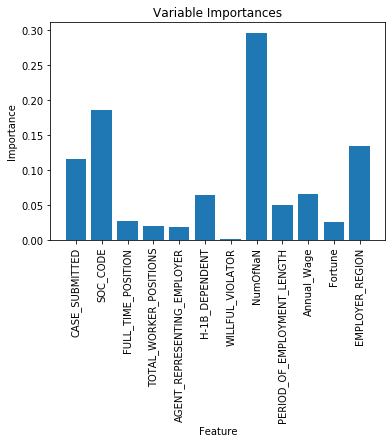

In [47]:
'''
Plot
'''
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, cat_feature, rotation = 'vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Variable Importances')

plt.show()

## Precision and Recall

AUC score:
No Skill = 0.5000
Random Forest = 0.7842


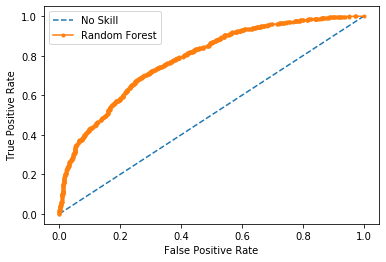

In [15]:
'''
ROC curve
'''
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

best_clf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=-1, oob_score=False, random_state=386, verbose=0,
                       warm_start=False) 

best_clf.fit(X, y)

# predict probabilities
rf_probs = best_clf.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# generate a `no-skill` prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print("AUC score:")
print('No Skill = %.4f' % (ns_auc))
print('Random Forest = %.4f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Precision = 0.872235
Recall    = 0.643226
F1 score  = 0.870438
AUC score = 0.904220


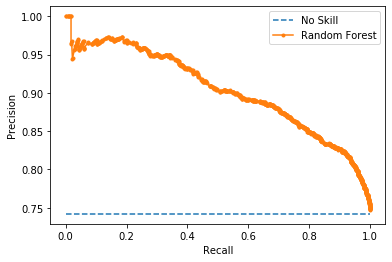

In [16]:
'''
Precision-Recall Curves
'''
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# predict class values
yhat = best_clf.predict(X_test)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_f1, rf_auc = f1_score(y_test, yhat), auc(rf_recall, rf_precision)

# summarize scores
print('Precision = %.6f' % (np.mean(rf_precision)))
print('Recall    = %.6f' % (np.mean(rf_recall)))
print('F1 score  = %.6f' % (rf_f1))
print('AUC score = %.6f' % (rf_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

[[ 209  102]
 [ 324 1431]] 

Precision: 0.815385
Recall:    0.933464
F1 score:  0.870438


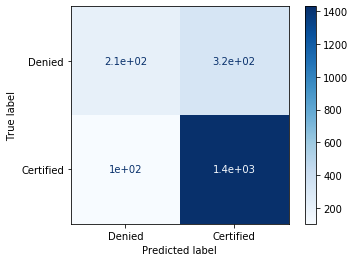

In [20]:
'''
Confusion Matrix
'''
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#yhat = best_clf.predict(X_test)
conf_mat = confusion_matrix(yhat, y_test)
print(conf_mat, '\n')

print("Precision: {:.6f}".format(precision_score(y_test, yhat)))
print("Recall:    {:.6f}".format(recall_score(y_test, yhat)))
print("F1 score:  {:.6f}".format(f1_score(y_test, yhat)))

disp = plot_confusion_matrix(best_clf, X_test, y_test,
                            display_labels=["Denied", "Certified"], 
                            cmap=plt.cm.Blues, normalize='true')

## Data Visualizations
1. OOB Error
    * n_estimators
    * max_features  
2. Validation Curves
    * n_estimators
    * max_depth
    * min_samples_split
    * min_samples_leaf

### - OOB Error

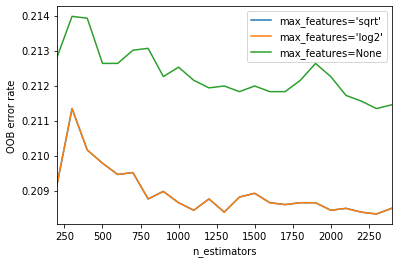

CPU times: user 5min 18s, sys: 6.01 s, total: 5min 24s
Wall time: 5min 29s


In [36]:
%%time
'''
OOB Errors 
(max_features, n_estimators)
'''
from collections import OrderedDict

# `warm_start`: disable support for parallelized ensembles
ensemble_clfs = [
    ("max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=random_state)),
    ("max_features='log2'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features='log2',
                               random_state=random_state)),
    ("max_features=None",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features=None,
                               random_state=random_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 200
max_estimators = 2400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators+1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
        # Record the OOB error
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate plot
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="best")
plt.grid()
plt.show()

### - Validation Curves

In [28]:
'''
Validation Curves
'''
from sklearn.model_selection import validation_curve

def run_validation_curves(param_name, param_range):
    train_scores, test_scores = validation_curve(clf, X = X, y = y, 
                                                 param_name = param_name, 
                                                 param_range = param_range, 
                                                 cv = 3)

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score")
    plt.plot(param_range, test_mean, label="Cross-validation score")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, color="lightskyblue")
    plt.fill_between(param_range, test_mean-test_std, test_mean+test_std, color="bisque")
    
    # Create plot
    plt.title("Validation Curve for {}".format(param_name))
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    return

#### n_estimators

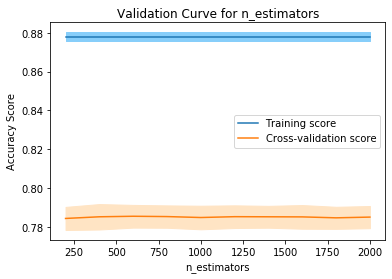

In [30]:
# 1. n_estimators
run_validation_curves("n_estimators", n_estimators)

#### max_depth

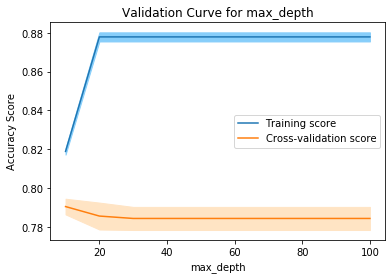

In [31]:
# 2. max_depth
param_range = max_depth
param_range.pop()
run_validation_curves("max_depth", param_range)

#### min_samples_split

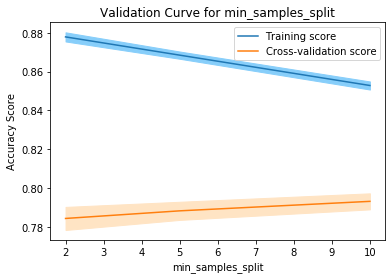

In [32]:
# 3. min_samples_split
run_validation_curves("min_samples_split", min_samples_split)

#### min_samples_leaf

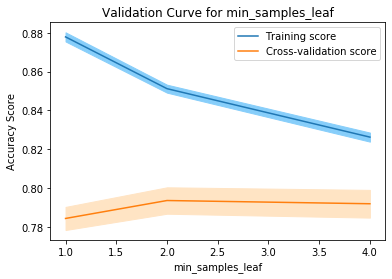

In [29]:
# 4. min_samples_leaf
run_validation_curves("min_samples_leaf", min_samples_leaf)